In [1]:
%run A_FunctionDefinitions.ipynb ; #Contains all definitions 

fdc_info=returnattributeset('fdc_info') #loads basic info
home='/Users/DJHeins/Documents/Coding/CAMELS/'

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold

In [2]:
minflowthresh=98 #Minimum flow threshold
acceptable=gaugefilter('fdc_info','PctFlow',[minflowthresh,101]) 
acceptablename='Flows' #Name for this subset

#datasets for each category
fdc=returnattributeset('fdc_info')[['gauge','PctFlow','m_90-10','err_1b','break']]
clim=returnattributeset('clim')[fieldlisting('clim')]
topo=returnattributeset('topo')[fieldlisting('topo')]
soil=returnattributeset('soil')[fieldlisting('soil')]
vege=returnattributeset('vege')[fieldlisting('vege')]
geol=returnattributeset('geol')[fieldlisting('geol')]

#making large dataframe of all
combined=pd.concat([fdc,clim,topo,soil,vege,geol],axis=1)
dfsubset=combined[combined.iloc[:,0].isin(acceptable)]
dfsubset.head(n=1)

,gauge,PctFlow,m_90-10,err_1b,break,p_mean,pet_mean,p_seasonality,frac_snow,aridity,...,organic_frac,other_frac,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,carbonate_rocks_frac,geol_porostiy,geol_permeability
0,1013500,100.0,3.102769,0.145291,36.0,3.126679,1.971555,0.18794,0.31344,0.630559,...,0.408717,0.0,0.9063,4.167304,3.340732,0.804567,0.371648,0.0,0.1714,-14.7019


In [3]:
#Identify any columns with incomplete data
described=dfsubset.describe()
described.iloc[0,:]

gauge                   559.0
PctFlow                 559.0
m_90-10                 559.0
err_1b                  559.0
break                   559.0
p_mean                  559.0
pet_mean                559.0
p_seasonality           559.0
frac_snow               559.0
aridity                 559.0
high_prec_freq          559.0
high_prec_dur           559.0
low_prec_freq           559.0
low_prec_dur            559.0
elev_mean               559.0
slope_mean              559.0
area_gages2             559.0
area_geospa_fabric      559.0
soil_depth_pelletier    559.0
soil_depth_statsgo      559.0
soil_porosity           559.0
soil_conductivity       559.0
max_water_content       559.0
sand_frac               559.0
silt_frac               559.0
clay_frac               559.0
water_frac              559.0
organic_frac            559.0
other_frac              559.0
frac_forest             559.0
lai_max                 559.0
lai_diff                559.0
gvf_max                 559.0
gvf_diff  

In [4]:
clim=fieldlisting('clim')
topo=fieldlisting('topo')
soil=fieldlisting('soil')
vege=fieldlisting('vege')
geol=fieldlisting('geol')
geo2=['carbonate_rocks_frac', 'geol_permeability'] #Removes porosity for having incomplete data

SeasonSnowArid = ['p_seasonality','frac_snow','aridity']

#Random forest target of regression
target='err_1b'

#Random forest/K-fold parameters
n_estimators=200
n_splits=5
n_repeats=10

#Create combination of desired column names, 
xvars=clim ; trialname='climate'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [5]:
dfsubset=combined[combined.iloc[:,0].isin(acceptable)]

X = dfsubset[xvars].values
y = dfsubset[target].values

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=20)

R2Values=[]
FeatureImport=[]

for train_index, test_index in rkf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sc = StandardScaler()  
    X_train = sc.fit_transform(X_train)  
    X_test = sc.transform(X_test)  

    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=0)  
    regressor.fit(X_train, y_train)  
    y_pred = regressor.predict(X_test)  
    r2score = metrics.r2_score(y_test, y_pred)
    R2Values.append(r2score)
    FeatureImport.append(regressor.feature_importances_)

importances = pd.DataFrame(np.asarray(FeatureImport),columns=xvars)
#importances.head(n=5)

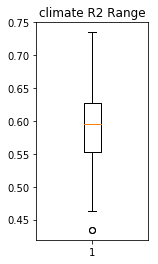

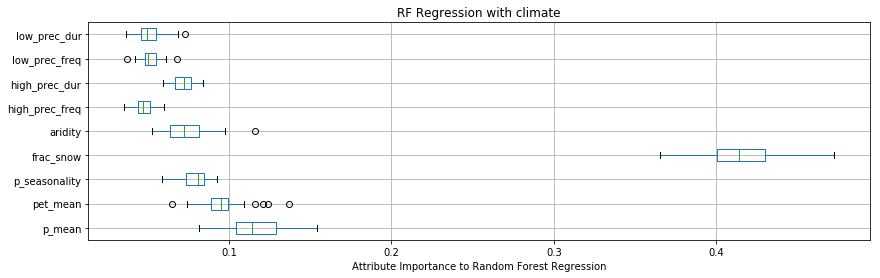

In [6]:
fig=plt.figure(figsize=(2,4))
plt.boxplot(R2Values)
plt.title(trialname+' R2 Range')
plt.show()

fig=plt.figure(figsize=(14,4))
importances.boxplot(vert=False)
plt.title('RF Regression with '+trialname)
plt.xlabel('Attribute Importance to Random Forest Regression')
plt.show()

In [7]:
#To compare R2 values, I ran this repeatedly with my desired combinations and saved R2Values under a new name each time